# Defect Calculation Parsing
For parsing defect calculation results with `doped`, we need the following VASP output files
from our bulk and defect supercell calculations:
- `vasprun.xml(.gz)`
- Either:
    - `OUTCAR(.gz)`, if using the Kumagai-Oba (eFNV) charge correction scheme (compatible with isotropic
     or anisotropic (non-cubic) dielectric constants; recommended), or
    - `LOCPOT(.gz)`, if using the Freysoldt (FNV) charge correction scheme (isotropic dielectric
    screening only).

Note that `doped` can read the compressed versions of these files (`.gz`/`.xz`/`.bz`/`.lzma`), so we can
 do e.g. `gzip OUTCAR` to reduce the file sizes when downloading and storing these files on our local
 system.

To quickly compress these output files on our HPC, we can run the following from our top-level folder
containing the defect directories (e.g. `Te_i_Te2.83_+2` etc):
```{shell}
for defect_dir in */vasp_*; do cd $defect_dir; gzip vasprun.xml OUTCAR; cd ../..; done
```
(change `OUTCAR` to `LOCPOT` if using the FNV isotropic charge correction), and then download the files
to the relevant folders by running the following from our local system:
```{shell}
for defect_dir in */vasp_*; do cd $defect_dir;
scp [remote_machine]:[path to doped folders]/${defect_dir}/\*gz .;
cd ../..; done
```
changing `[remote_machine]` and `[path to doped folders]` accordingly.

##  Example: <it>V</it><sub>Cd</sub> Defect Calculations
In this example, we parse some cadmium vacancy calculations (V<sub>Cd</sub>) with `doped`. In this case, these
 defects weren't initially generated with `doped`, but this is fine, as `doped` can parse the
 results
 and automatically determine the defect type and site from the relaxed structure.

In [2]:
import os
from doped import analysis

In [2]:
bulk_path = "CdTe/CdTe_bulk/vasp_ncl"  # path to our bulk supercell calculation
dielectric = 9.13  # dielectric constant (this can be a single number (isotropic), or a 3x1 array or 3x3 matrix (anisotropic))

In [3]:
v_Cd_dict = {}  # dictionary of parsed vacancy defect entries

for i in os.listdir("CdTe"):  # loops through the example directory
    if 'v_Cd' in i:  # and parses folders that have "v_Cd" in their name
        print(f"Parsing {i}...")
        defect_path = f"CdTe/{i}/vasp_ncl" # here our calculation outputs are in `vasp_ncl` subfolders (e.g. v_Cd_0/vasp_ncl/ etc)
        v_Cd_dict[i] = analysis.defect_entry_from_paths(defect_path, bulk_path, dielectric)

Parsing v_Cd_0...
Parsing v_Cd_-1...
Parsing v_Cd_-2...


In the above `defect_entry_from_paths()` function, we only have to specify the paths to the bulk and
defect supercell calculations, and the dielectric constant. `doped` then automatically determines the
defect type and site from the relaxed defect structure, as well as its charge state. `doped` then attempts
to perform the finite-size charge corrections for this defect, using the calculation outputs (requires `OUTCAR` files for the Kumagai-Oba (eFNV) correction (compatible with isotropic or anisotropic dielectric screening), or `LOCPOT` files for the Freysoldt (FNV) correction (isotropic only)).

If the charge correction is not compatible with the defect/dielectric, informative warning messages about this will be shown.

```{tip}
Note that you could also use something like:

    parsed_defect_dict = {}
    for i in os.listdir():  # loop through all files/folders in current directory
        if os.path.exists(f"{i}/vasp_std"):  # vasp_std subfolder present
            print(f"Parsing {i}...")
            defect_path = f"CdTe/{i}/vasp_std" # assuming here our VASP outputs are in `vasp_std` subfolders
            parsed_defect_dict[i] = analysis.defect_entry_from_paths(defect_path, bulk_path, dielectric)

to loop over your calculation directories, or any other way you want.
```

With our dictionary of parsed defect entries, we can then query some of the defect-specific results, such as the finite-size charge corrections, the defect site, and energy (without accounting for chemical potentials yet):

In [4]:
print("V_Cd^-2:")
print(f"Charge: {v_Cd_dict['v_Cd_-2'].charge_state} at site: "
      f"{v_Cd_dict['v_Cd_-2'].defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {v_Cd_dict['v_Cd_-2'].corrections}")
print("\nV_Cd^0:")
print(f"Charge: {v_Cd_dict['v_Cd_0'].charge_state} at site: "
      f"{v_Cd_dict['v_Cd_0'].defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {v_Cd_dict['v_Cd_0'].corrections}")

V_Cd^-2:
Charge: -2 at site: [0. 0. 0.]
Finite-size charge corrections: {'freysoldt_charge_correction': 0.7376460317828045}

V_Cd^0:
Charge: 0 at site: [0.5 0.5 0.5]
Finite-size charge corrections: {}


As mentioned in the [defect generation tutorial](https://doped.readthedocs.io/en/latest/dope_workflow_example.html),
we can save `doped` outputs to JSON files and then share or reload them later on, without needing to
re-run the parsing steps above. Here we save our parsed defect entries using the `dumpfn`
function from `monty.serialization`:

In [5]:
from monty.serialization import dumpfn, loadfn
dumpfn(v_Cd_dict, "v_Cd_dict.json")  # save parsed defect entries to file

In [6]:
# we can then reload these parsed defect entries from file at any later point with:
v_Cd_dict = loadfn("v_Cd_dict.json")

We can quickly look at the charge correction plots if we want (recommended if any warnings about charge correction compatibility / delocalization analysis are given) using:

```{note}
Typically we only analyze the charge correction plots like this if there has been some warning
 or error related to the defect charge correction (i.e. "delocalization analysis" warnings) – here we're just showing as a demonstration)
```

In [7]:
from doped.utils.corrections import get_correction_freysoldt

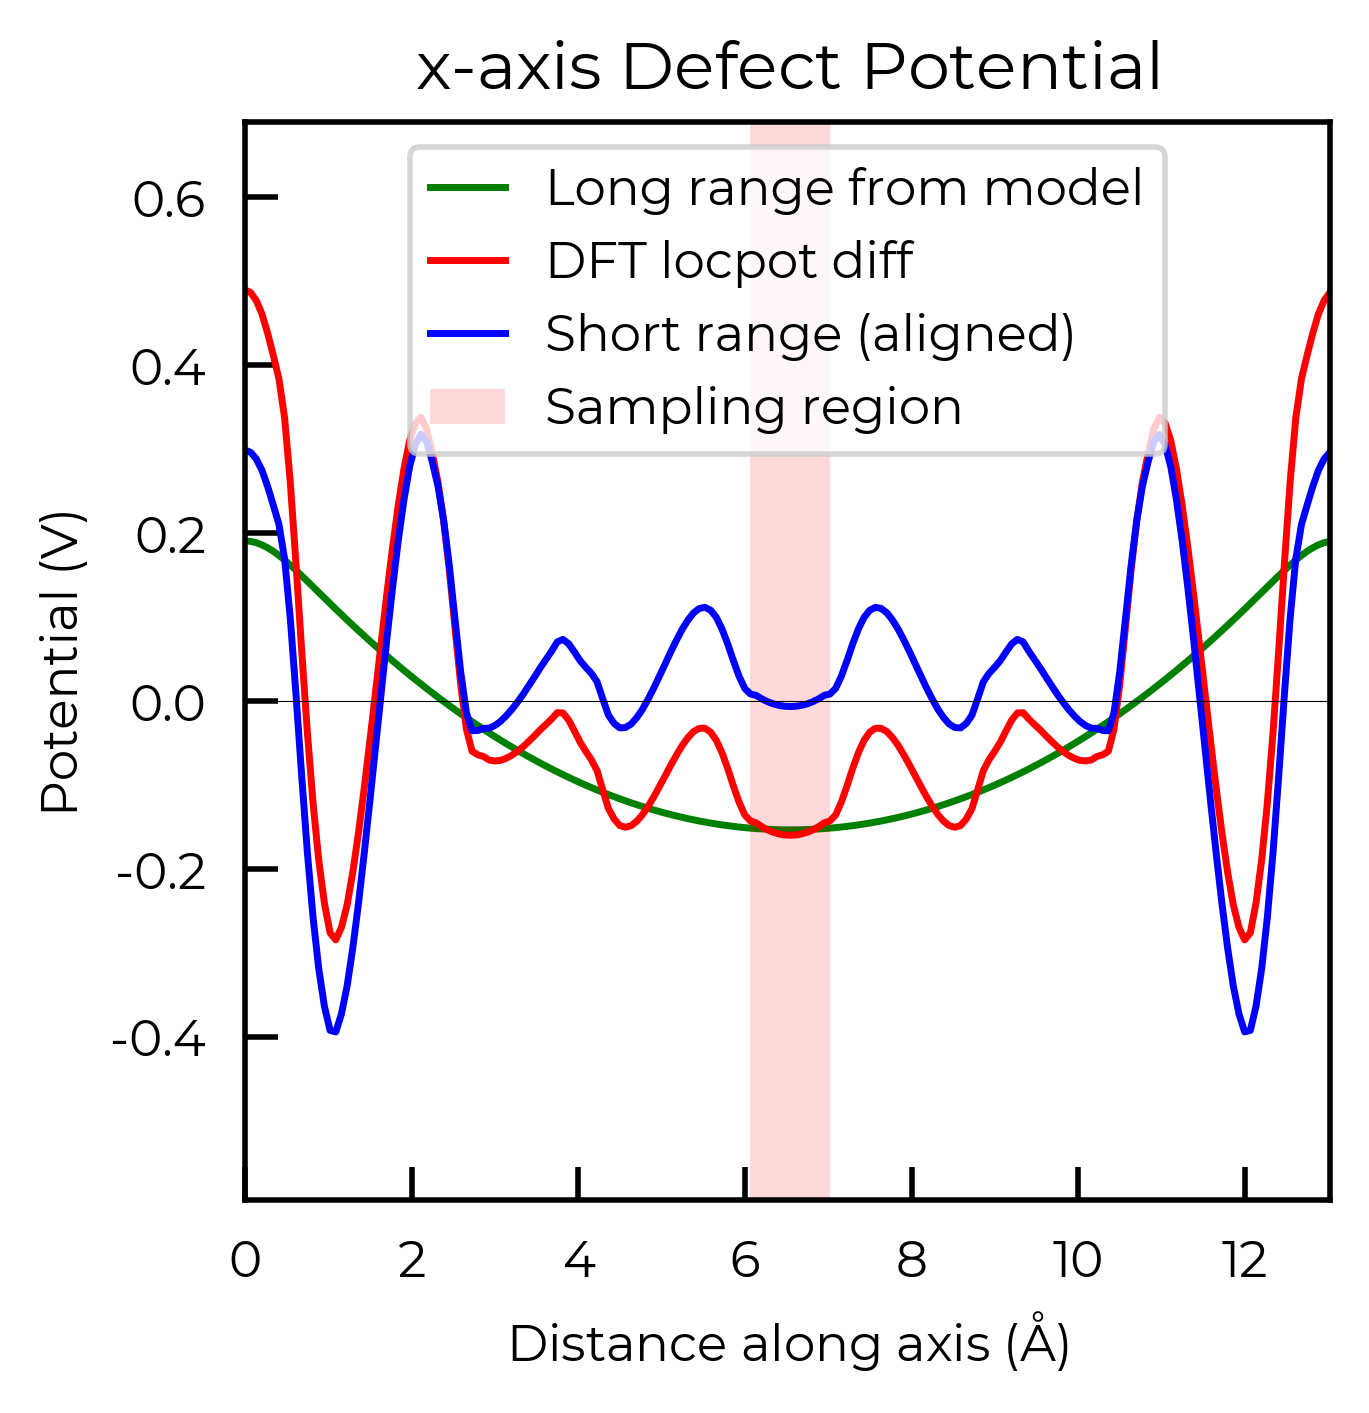

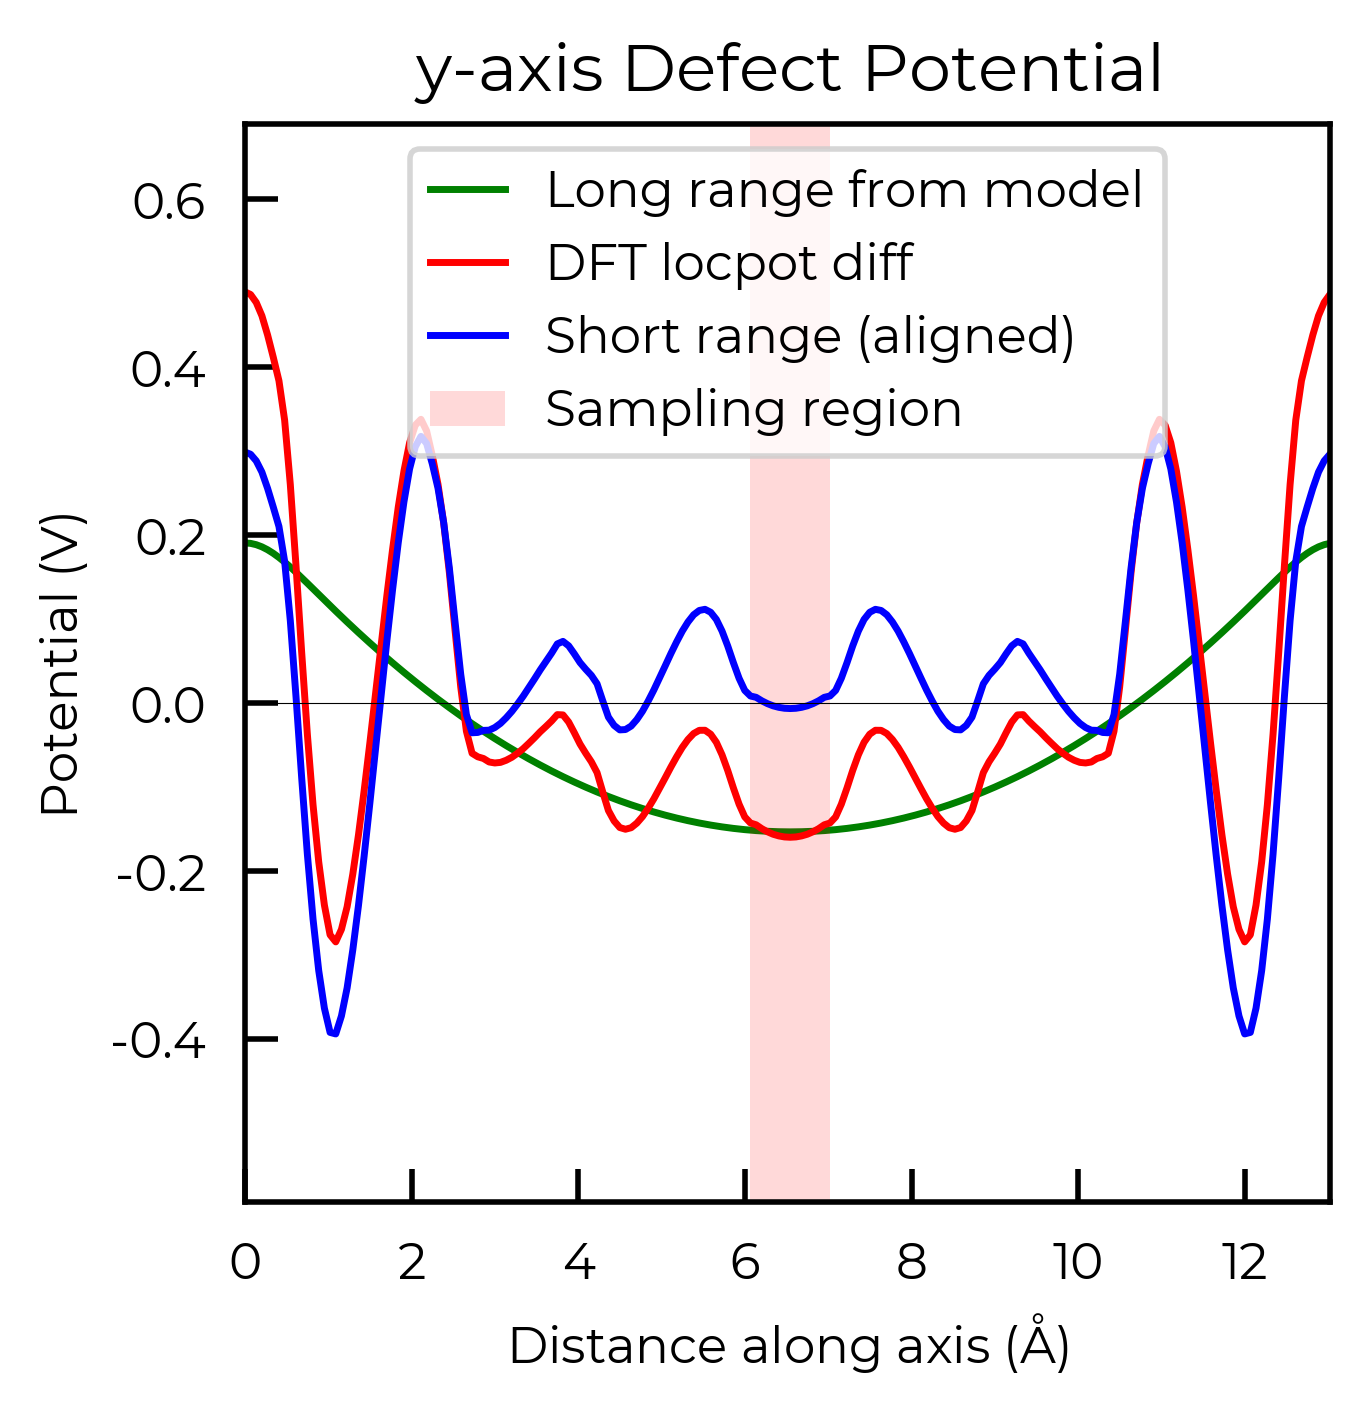

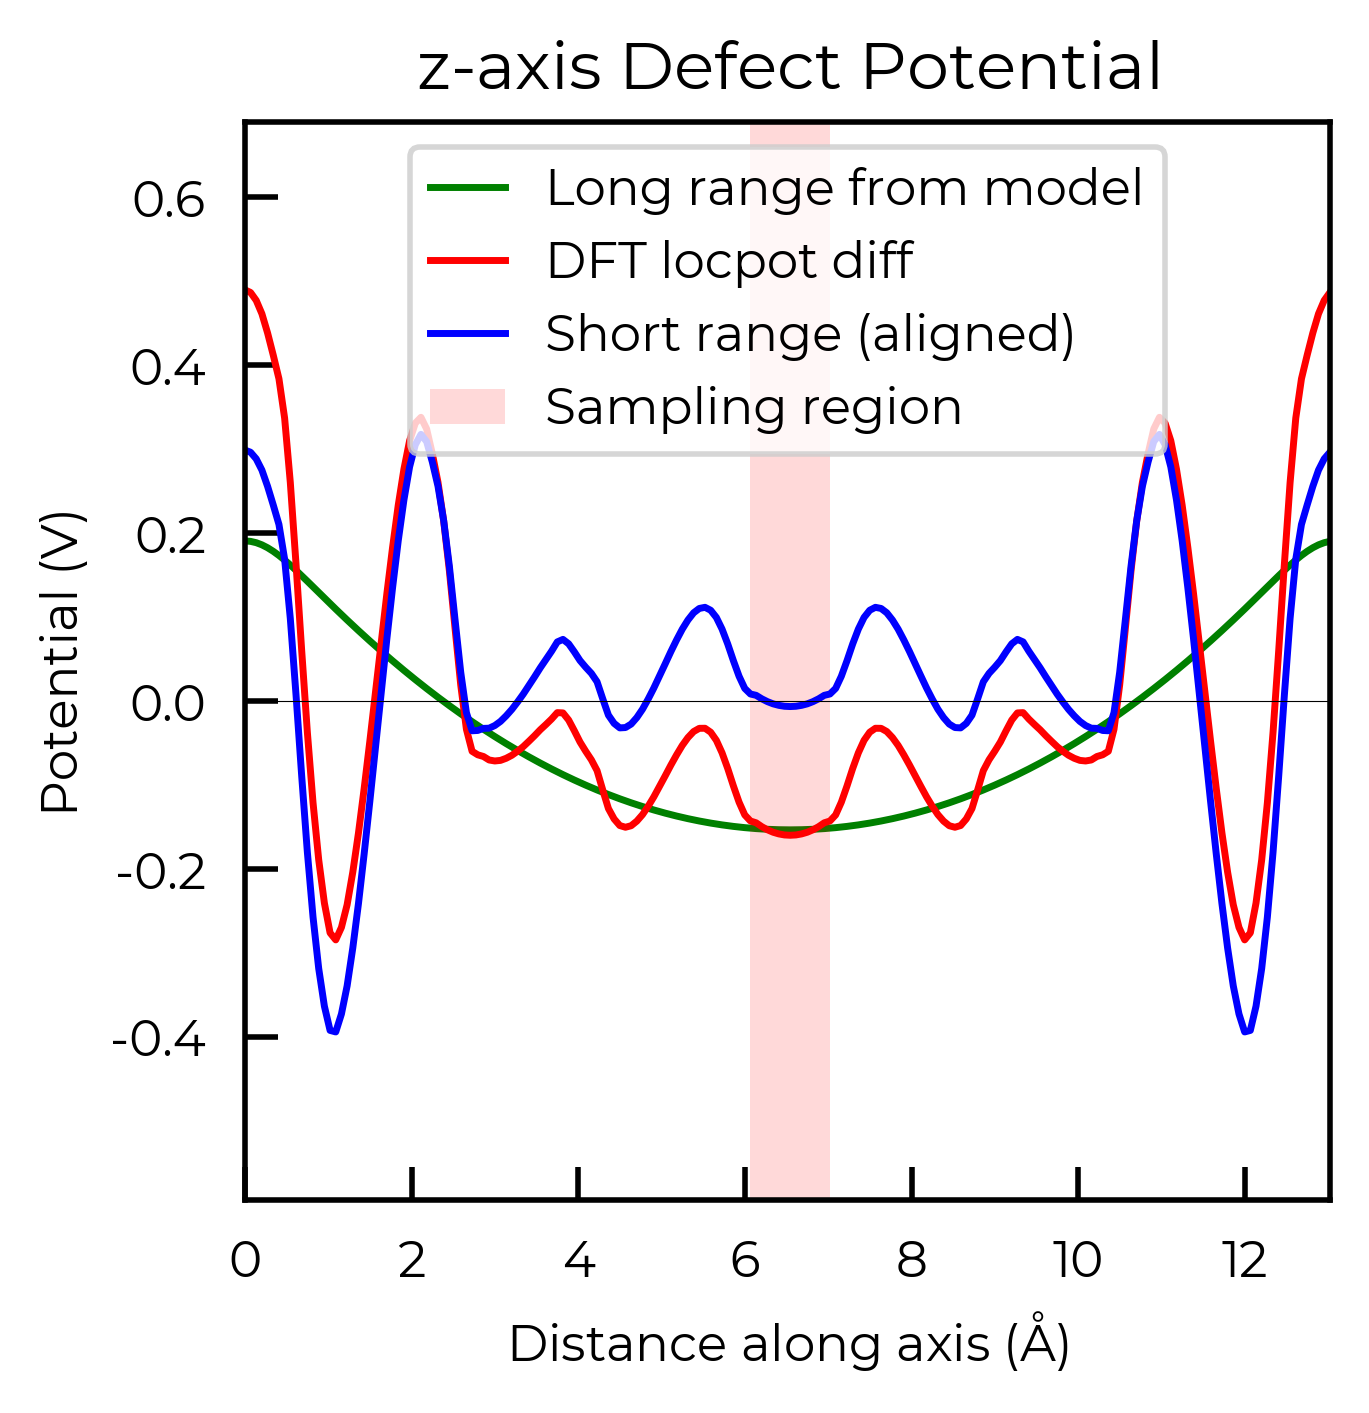

Final Freysoldt correction is 0.738 eV


In [8]:
frey_corr = get_correction_freysoldt(v_Cd_dict["v_Cd_-2"], 9.13, plot = True)

Note that here we have used the Freysoldt (FNV) image charge correction scheme, which assumes an isotropic dielectric screening and so should only be used with **_isotropic/cubic host materials_**.
`doped` also supports the Kumagai-Oba (eFNV) charge correction scheme, which allows for anisotropic
dielectric screening and so should be used for **_anisotropic/non-cubic host materials_** (example
below, see sidebar).

`doped` will automatically perform the appropriate charge correction method for your system, based on
the supplied `dielectric` constant (i.e. anisotropic or isotropic) and calculation outputs, and will
warn you if any required outputs are missing.

## Defect Formation Energy / Transition Level Diagrams

```{tip}
Defect formation energy (a.k.a. transition level diagrams) are one of the key results from a
computational defect study, giving us a lot of information on the defect thermodynamics and electronic behaviour.
```

```{important}
To calculate and plot the defect formation energies, we generate a `DefectPhaseDiagram` object, which
can be created using the `analysis.dpd_from_defect_dict()` function, which takes a dictionary of parsed
defect entries and outputs the `DefectPhaseDiagram`:
```

In [9]:
# generate DefectPhaseDiagram object, with which we can plot/tabulate formation energies, calculate charge transition levels etc:
v_Cd_dpd = analysis.dpd_from_defect_dict(v_Cd_dict)
dumpfn(v_Cd_dpd, "v_Cd_dpd.json")  # save parsed DefectPhaseDiagram to file, so we don't need to regenerate it later

To calculate and plot defect formation energies, we need to know the chemical potentials of the elements
 in the system (see the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg) for more details on
 this).
The workflow for computing and analysing the chemical potentials is described in the [Competing Phases
tutorial](https://doped.readthedocs.io/en/latest/dope_chemical_potentials.html), and here we have already
done this for our CdTe system, so we can just load the results from the JSON file here:

In [6]:
# load CdTe parsed chemical potentials (needed to compute the defect formation energies)
cdte_chempots = loadfn("CdTe/cdte_chempots.json")

In [11]:
print(cdte_chempots)

{'facets': {'Cd-CdTe': {'Cd': -1.01586484, 'Te': -5.7220097228125}, 'CdTe-Te': {'Cd': -2.2671822228125, 'Te': -4.47069234}}, 'elemental_refs': {'Te': -4.47069234, 'Cd': -1.01586484}, 'facets_wrt_elt_refs': {'Cd-CdTe': {'Cd': 0.0, 'Te': -1.2513173828125002}, 'CdTe-Te': {'Cd': -1.2513173828125, 'Te': 0.0}}}


Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. phase diagram facets),
 rather than typing out the chemical potentials obtained from a different method / manually.
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `facets_wrt_elt_refs` entry in the `cdte_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding phase diagram facet / chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

Basic formation energy plot:

<Figure size 1400x1400 with 0 Axes>

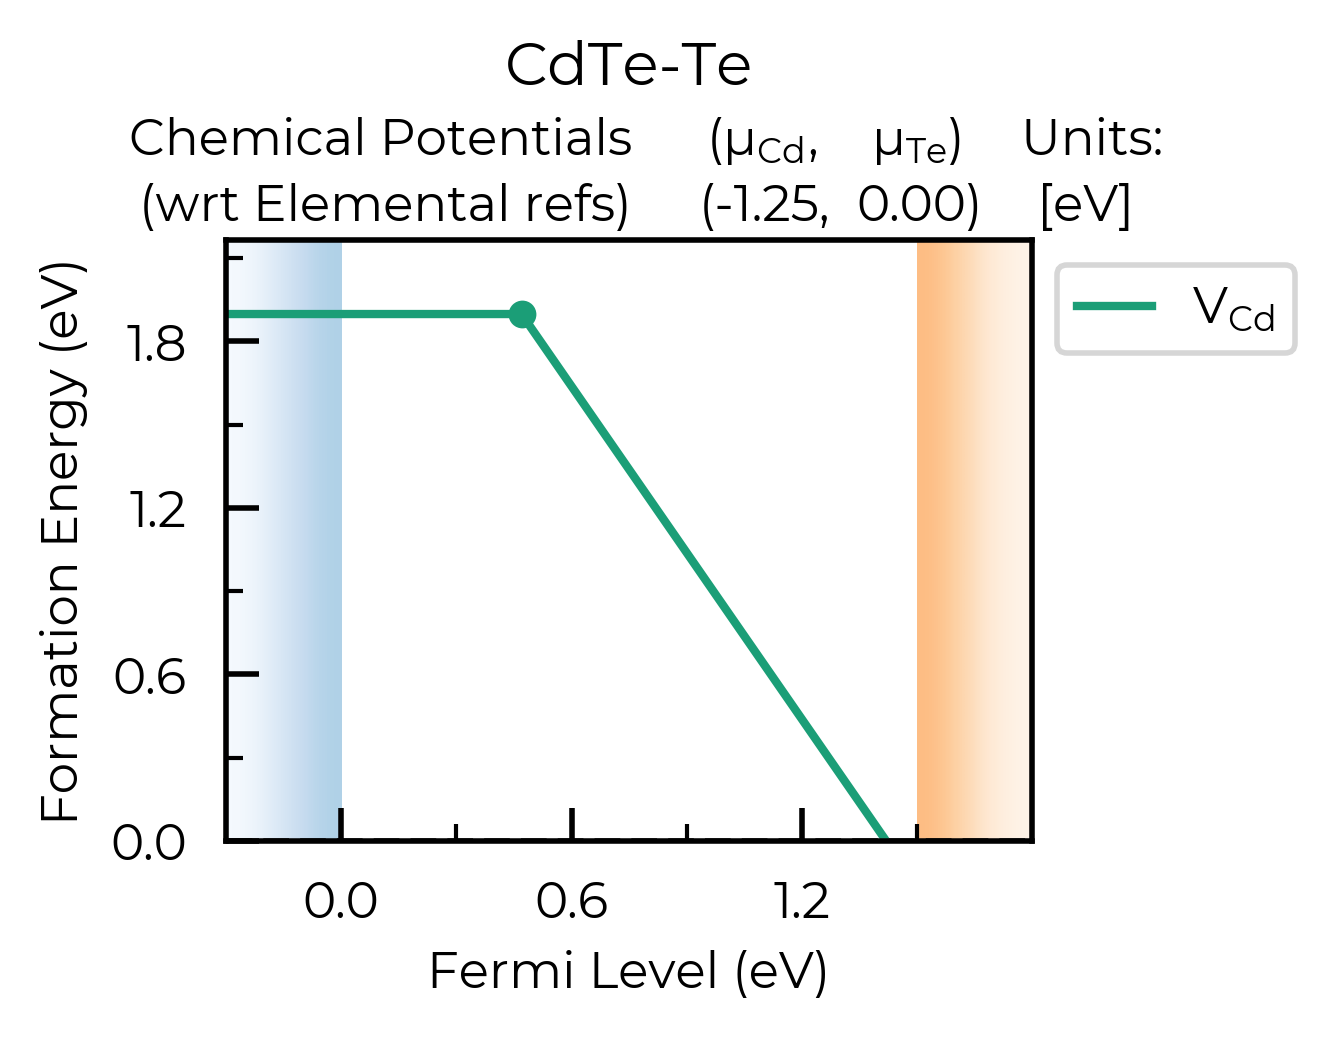

In [4]:
from doped import plotting
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    cdte_chempots,
    facets=["CdTe-Te"],
)

There are a lot of options for making the formation energy plot prettier:

In [4]:
# run this cell to see the possible arguments for this function:
plotting.formation_energy_plot?

Signature:
plotting.formation_energy_plot(
    defect_phase_diagram,
    chempots: Optional[Dict] = None,
    facets: Union[List, str, NoneType] = None,
    elt_refs: Optional[Dict] = None,
    chempot_table: bool = True,
    all_entries: Union[bool, str] = False,
    style_file: Optional[str] = None,
    xlim: Optional[Tuple] = None,
    ylim: Optional[Tuple] = None,
    fermi_level: Optional[float] = None,
    colormap: str = 'Dark2',
    auto_labels: bool = False,
    filename: Optional[str] = None,
)
Docstring:
Produce a defect formation energy vs Fermi level plot (a.k.a. a defect
formation energy / transition level diagram). Returns the Matplotlib Figure
object to allow further plot customisation.

Args:
    defect_phase_diagram (DefectPhaseDiagram):
        DefectPhaseDiagram for which to plot defect formation energies
        (typically created from analysis.dpd_from_defect_dict).
    chempots (dict):
        Dictionary of chemical potentials to use for calculating the defect
  

<Figure size 1400x1400 with 0 Axes>

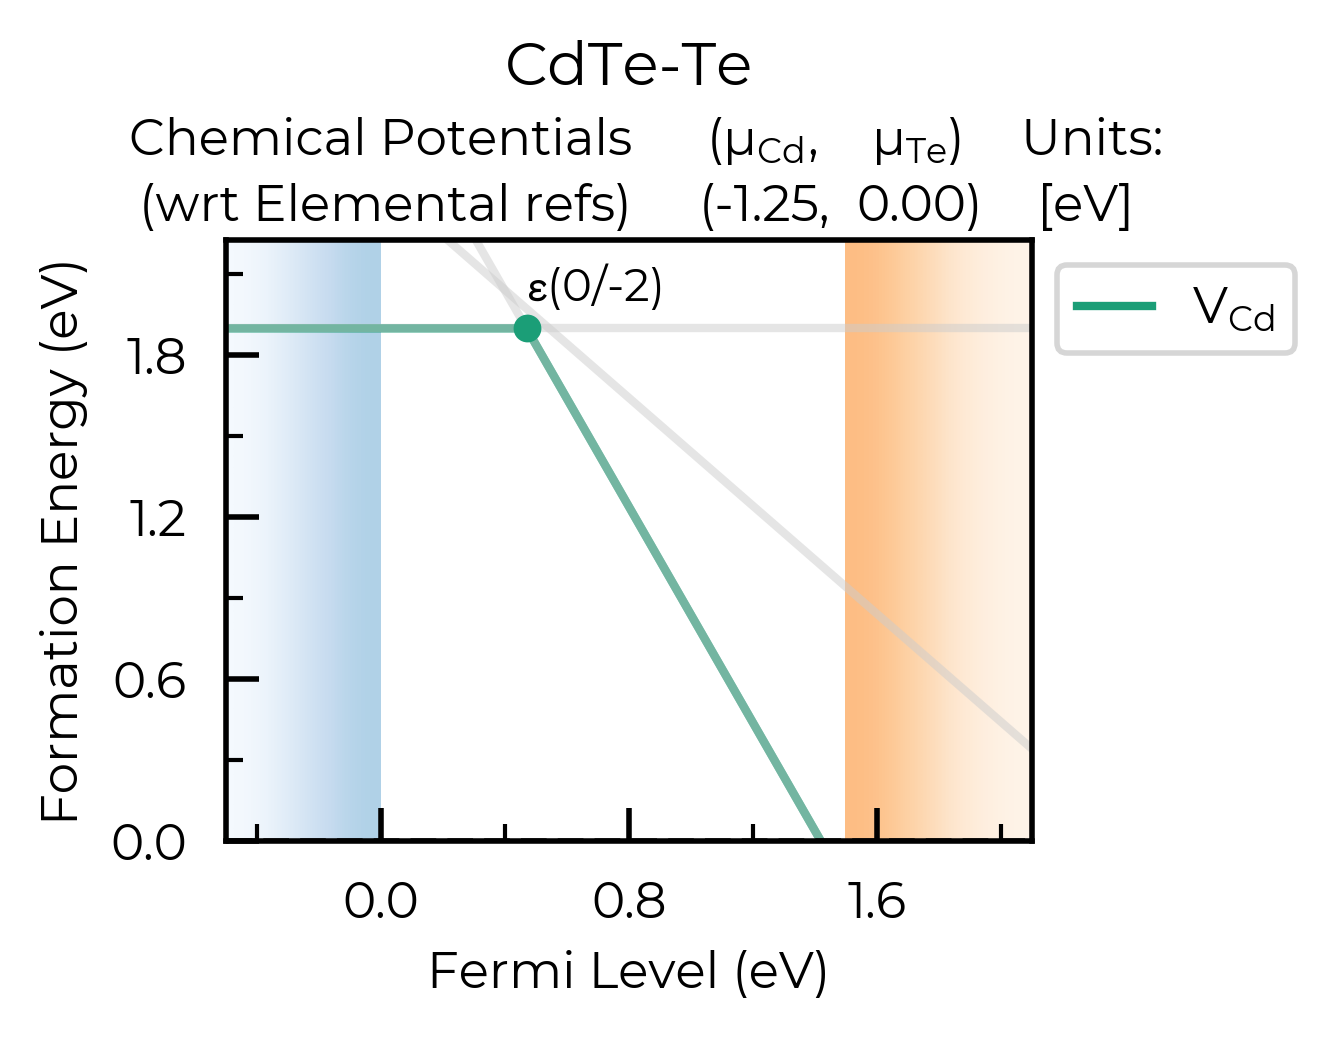

In [5]:
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    cdte_chempots,
    auto_labels=True,
    xlim=(-0.5, 2.1),
    all_entries="faded",
    facets=["CdTe-Te"],
    filename="V_Cd_Formation_Energy_Te-Rich.pdf",
)

`plotting.formation_energy_plot` also returns the `matplotlib` plot object, so you can customise this as much as you like!

#### Manually inputting chemical potentials:

<Figure size 1400x1400 with 0 Axes>

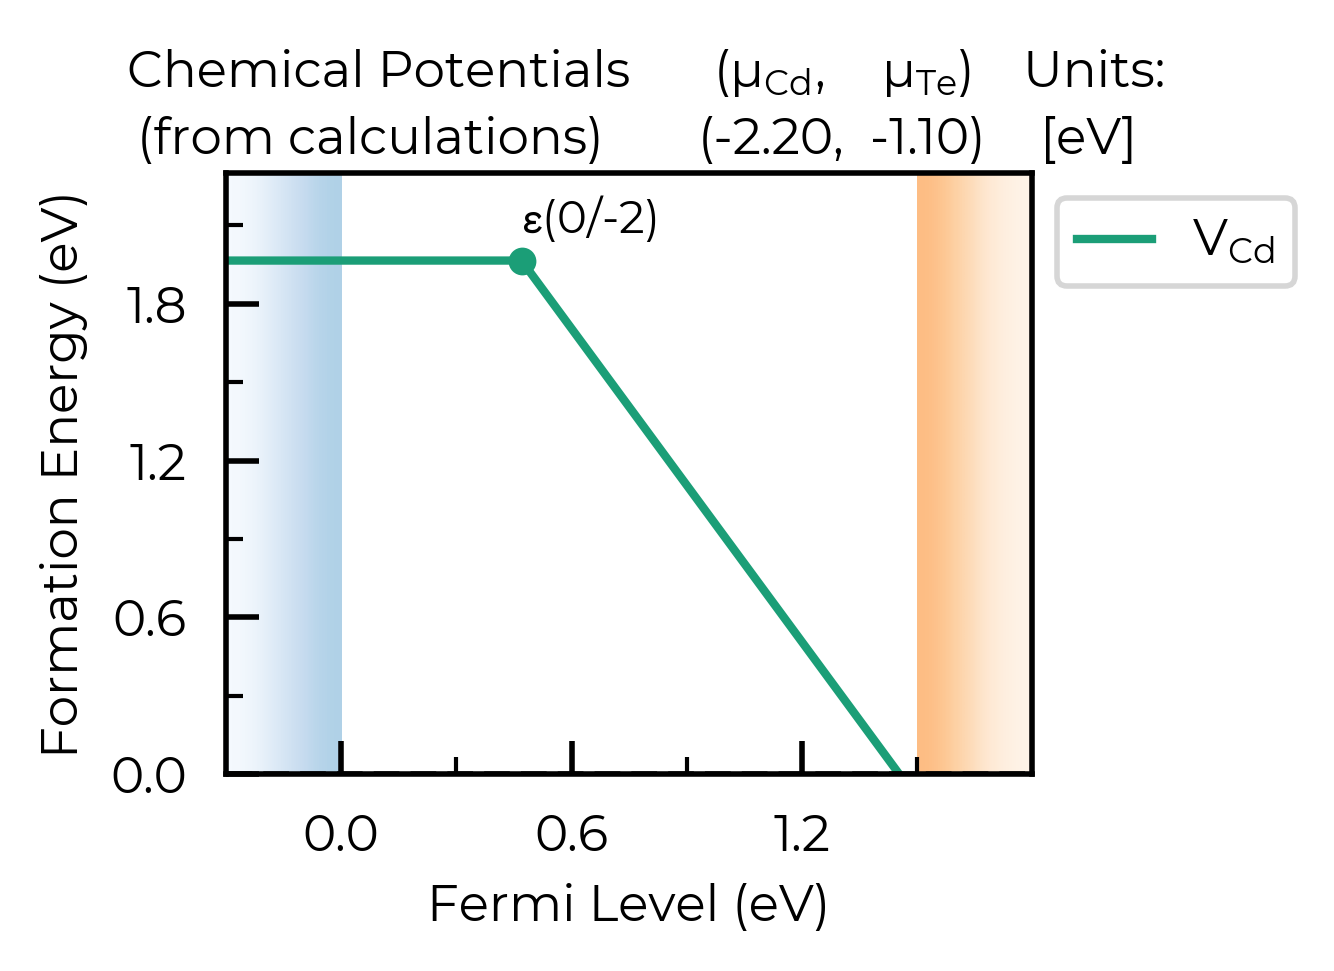

In [6]:
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    chempots = {"Cd": -2.2, "Te": -1.1},
    auto_labels=True,
)

<Figure size 1400x1400 with 0 Axes>

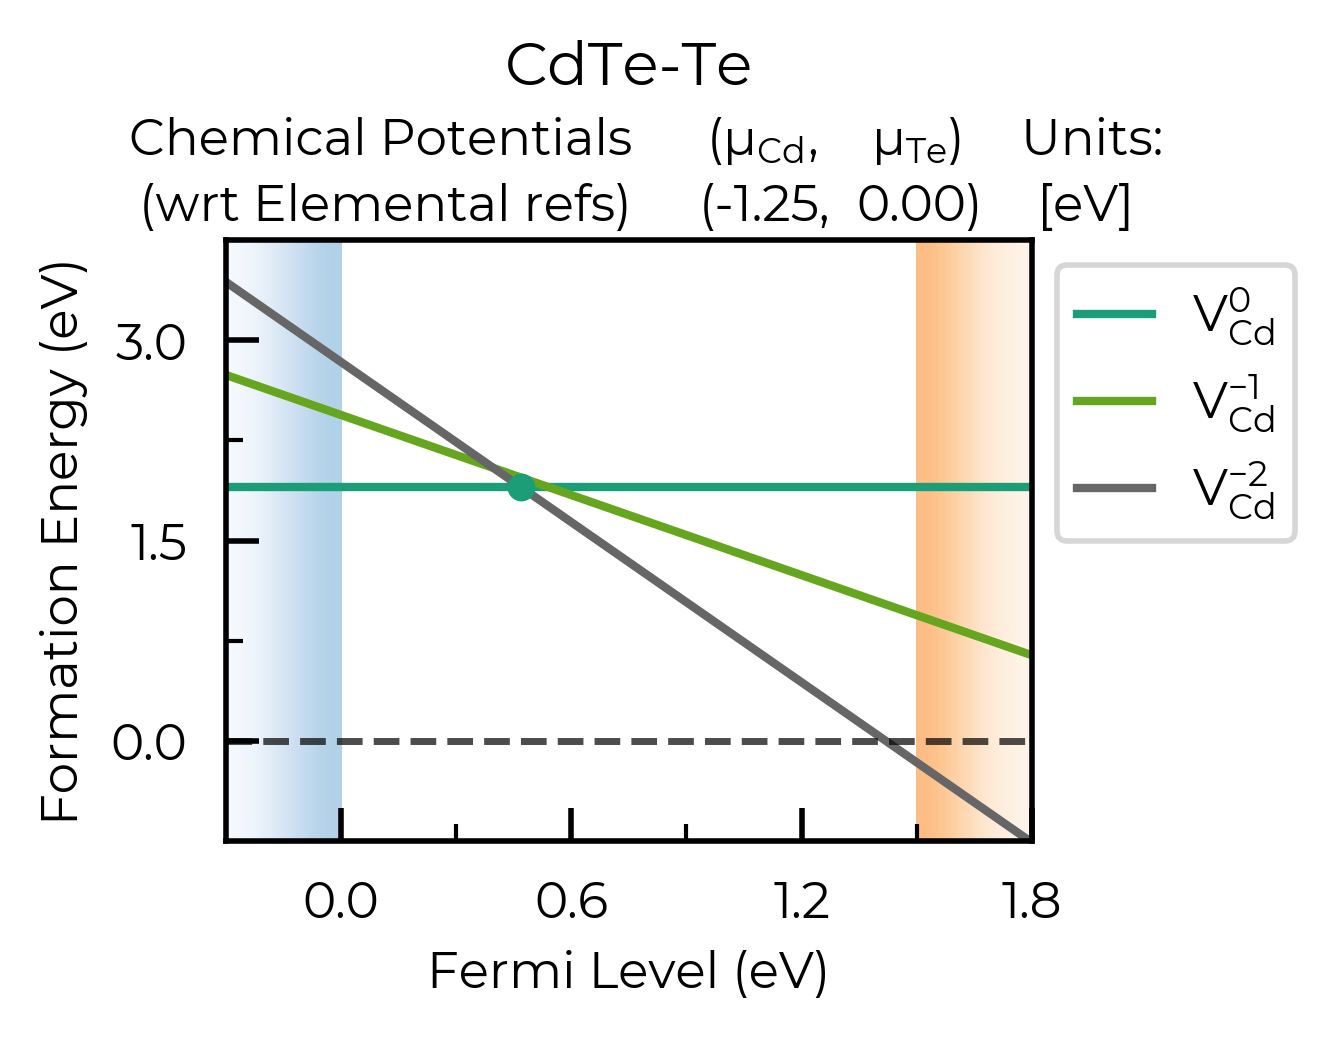

In [7]:
def_plot = plotting.formation_energy_plot(
    v_Cd_dpd,
    cdte_chempots,
    all_entries=True,  # show the full formation energy lines for all defect charge states
    xlim=(-0.3, 1.8),
    ylim=(-0.75,3.75),  # adjust y-axis
    facets=["CdTe-Te"],
    filename="V_Cd_Te-Rich_All_Lines.pdf"
)

If you have parsed all your calculated defects as above with `doped` and created the `DefectPhaseDiagram` object (e.g. `CdTe_defects_dpd` in this example), you can also plot the formation energies of all the defects together, as shown below:

In [3]:
CdTe_defects_dpd = loadfn("CdTe/CdTe_defects_dpd_for_plotting.json")  # not available yet on GitHub

<Figure size 1400x1400 with 0 Axes>

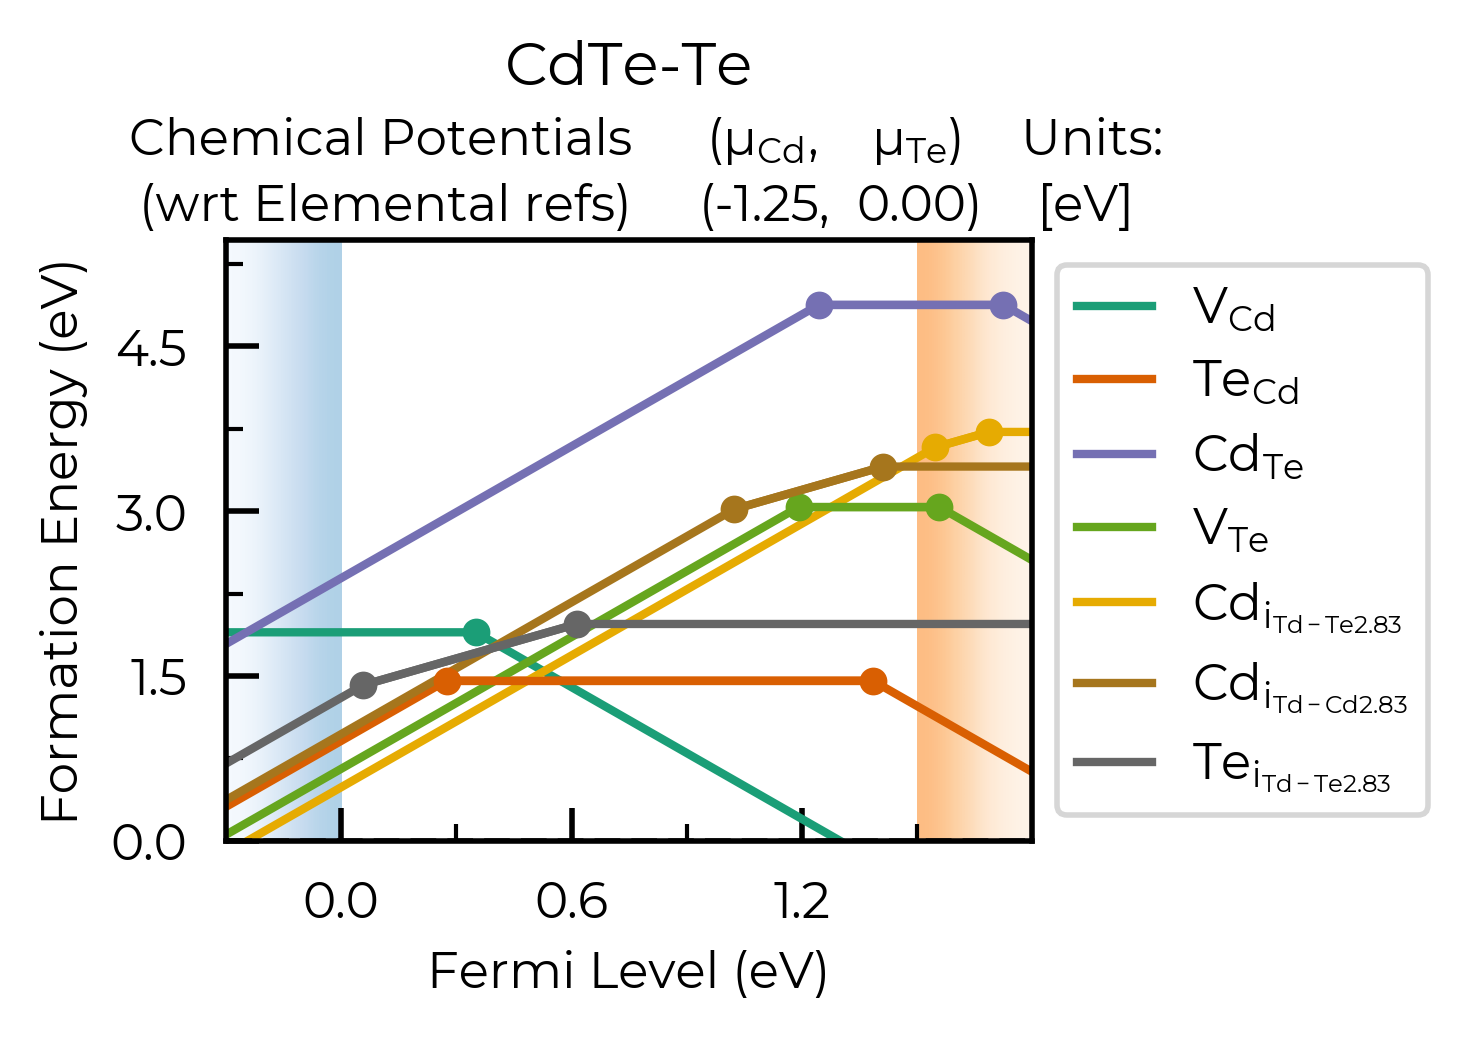

In [8]:
# Example plot of final results:
def_plot = plotting.formation_energy_plot(
    CdTe_defects_dpd,
    cdte_chempots,
    facets=["CdTe-Te"],
)

Nice! Here we can see our different inequivalent sites for the interstitials are automatically labelled
in our plot legend (using the `doped` naming functions), showing that the lowest energy cadmium
interstitial site actually differs between +2 and neutral charge states, as has been noted in this
system in the [literature](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.054108).

### Formation Energy Tables

We can also get tables of the defect formation energies (including terms in the formation energy equation,
such as the charge correction and chemical potentials), as shown below:

In [12]:
list_of_dfs = analysis.formation_energy_table(
    v_Cd_dpd,
    cdte_chempots,
)

Facet: Cd-CdTe
╒══════════╤═════╤═══════════════════════╤═════════╤══════════╤══════════╤══════════╕
│ Defect   │ q   │ Path                  │ ΔEʳᵃʷ   │ E_corr   │ Σμ       │ ΔEᶠᵒʳᵐ   │
╞══════════╪═════╪═══════════════════════╪═════════╪══════════╪══════════╪══════════╡
│ v_Cd_0   │ 0   │ CdTe/v_Cd_0/vasp_ncl  │ 4.17 eV │ 0.00 eV  │ -1.02 eV │ 3.15 eV  │
├──────────┼─────┼───────────────────────┼─────────┼──────────┼──────────┼──────────┤
│ v_Cd_-1  │ -1  │ CdTe/v_Cd_-1/vasp_ncl │ 6.13 eV │ 0.23 eV  │ -1.02 eV │ 3.69 eV  │
├──────────┼─────┼───────────────────────┼─────────┼──────────┼──────────┼──────────┤
│ v_Cd_-2  │ -2  │ CdTe/v_Cd_-2/vasp_ncl │ 7.66 eV │ 0.74 eV  │ -1.02 eV │ 4.09 eV  │
╘══════════╧═════╧═══════════════════════╧═════════╧══════════╧══════════╧══════════╛ 

Table Key:
'Defect' -> Defect type and multiplicity.
'q' -> Defect charge state.
'ΔEʳᵃʷ' -> Energy difference between defect and host supercell (E_defect - E_host).
(chemical potentials set to 0 and the fermi 

In [5]:
analysis.formation_energy_table?

Signature:
analysis.formation_energy_table(
    defect_phase_diagram: doped.utils.legacy_pmg.thermodynamics.DefectPhaseDiagram,
    chempot_limits: Optional[Dict] = None,
    facets: Optional[List] = None,
    fermi_level: float = 0,
    hide_cols: Optional[List] = None,
    show_key: bool = True,
)
Docstring:
Prints defect formation energy tables for either a single chemical potential limit (i.e. phase
diagram facet) or each facet in the phase diagram (chempot_limits dict), depending on the
chempot_limits input supplied. This can either be a dictionary of chosen absolute/DFT chemical
potentials: {Elt: Energy} (giving a single formation energy table) or a dictionary including
the key-value pair: {"facets": [{'facet': [chempot_dict]}]}, following the format generated
by chempot_limits = cpa.read_phase_diagram_and_chempots() (see example notebooks). In the
latter case, a subset of facet(s) / chemical potential limit(s) can be chosen with the
facets argument, or if not specified, will pri

```{tip}
The `formation_energy_table` function returns a list of `pandas.DataFrame` objects (or a single
`DataFrame` object if a certain chemical potential `facet` was chosen), which we can save to csv as
shown below. As a `csv` file, this can then be easily imported to `Microsoft Word` or to `LaTeX` (using
e.g.
<a href="https://www.tablesgenerator.com/latex_tables">https://www.tablesgenerator.com/latex_tables</a>)
 to be included in Supporting Information of papers or
 in theses, which we would recommend for open-science, queryability and reproducibility!
```

In [14]:
list_of_dfs[0].to_csv(f"V_Cd_Formation_Energies_Cd_Rich.csv")

In [15]:
!head V_Cd_Formation_Energies_Cd_Rich.csv

,Defect,q,Path,ΔEʳᵃʷ,E_corr,Σμ,ΔEᶠᵒʳᵐ
0,v_Cd_0,0,CdTe/v_Cd_0/vasp_ncl,4.17 eV,0.00 eV,-1.02 eV,3.15 eV
1,v_Cd_-1,-1,CdTe/v_Cd_-1/vasp_ncl,6.13 eV,0.23 eV,-1.02 eV,3.69 eV
2,v_Cd_-2,-2,CdTe/v_Cd_-2/vasp_ncl,7.66 eV,0.74 eV,-1.02 eV,4.09 eV


## Kumagai-Oba (eFNV) Charge Correction Example:

Above, we used the Freysoldt (FNV) defect image charge correction scheme, which is compatible only with
isotropic dielectric screening. `doped` also supports the Kumagai-Oba (eFNV) charge correction scheme,
which should be used for systems with anisotropic dielectric screening. In fact in general, we recommend
 using the `eFNV` correction scheme, as it is more general (can be used for both isotropic and
 anisotropic systems) and the numerical implementation is more efficient, requiring smaller file sizes
 (only requires `OUTCAR(.gz)` files, rather than the larger `LOCPOT(.gz)` files) and running quicker.

Here we're taking the example of a Fluorine-on-Oxygen antisite substitution defect in Y<sub>2</sub>Ti<sub>2</sub>O<sub>5</sub>S<sub>2</sub> (a potential photocatalyst and _n_-type thermoelectric), which has a non-cubic anisotropic structure and
 dielectric constant:

In [20]:
F_O_1_entry = analysis.defect_entry_from_paths(defect_path="YTOS/F_O_1", bulk_path="YTOS/Bulk",
                                                dielectric = [40.7, 40.7, 25.2])
print(f"Charge: {F_O_1_entry.charge_state} at site: {F_O_1_entry.defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {F_O_1_entry.corrections}")

Charge: 1 at site: [1.         0.99999999 0.        ]
Finite-size charge corrections: {'kumagai_charge_correction': 0.08209990653805896}


Above, the defect has been parsed and the anisotropic (eFNV) charge correction correctly applied, with no warnings thrown. We can directly plot the atomic site potentials which are used to compute this charge correction if we want:
(Though typically we only do this if there has been some warning or error related to the application of the defect charge correction – here we're just showing as a demonstration)

In [21]:
from doped.utils.corrections import get_correction_kumagai

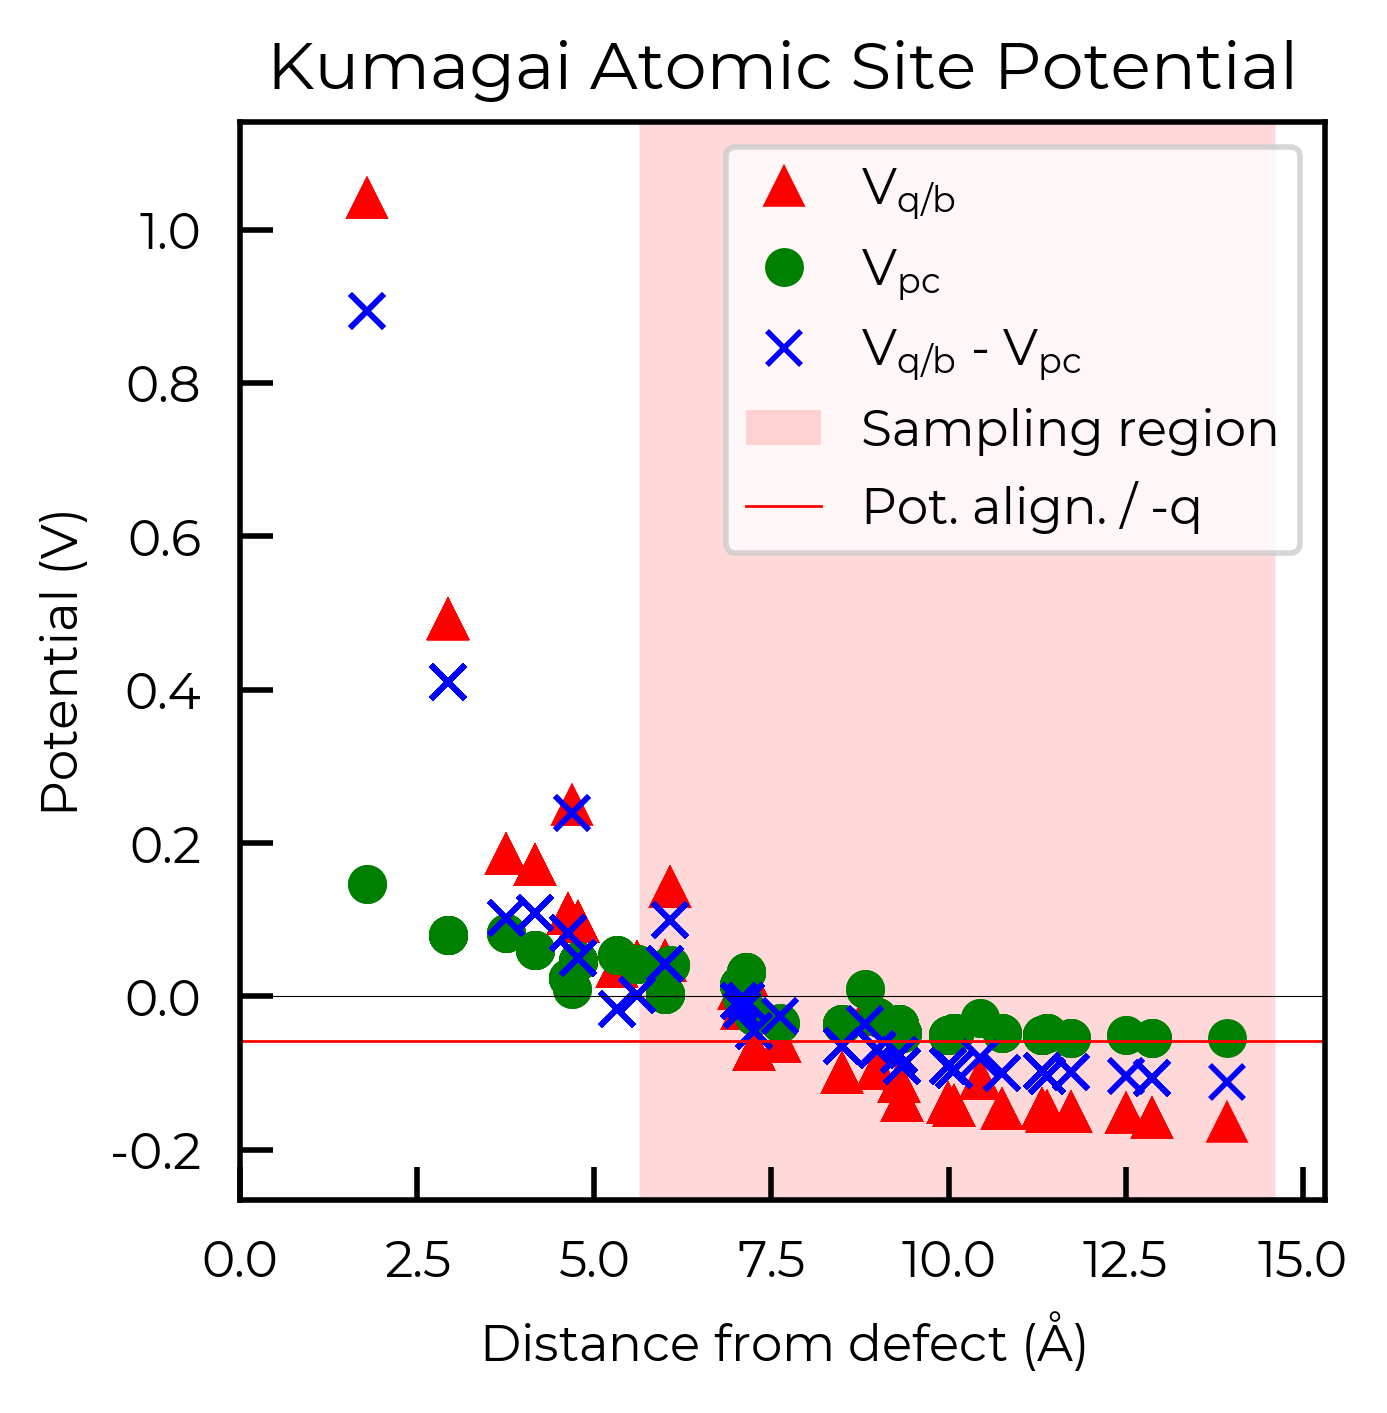


Final Kumagai correction is 0.082 eV


0.08209990653805896

In [22]:
get_correction_kumagai(F_O_1_entry, dielectric=[40.7, 40.7, 25.2], plot=True)

## Further Defect Analysis

As briefly discussed in the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg), you will likely
want to further analyse the key defect species in your material, by e.g. visualising the relaxed
structures with `VESTA`/`CrystalMaker`, looking at the defect single-particle energy levels using the
[sumo](https://smtg-ucl.github.io/sumo/) DOS plotting functions (`sumo-dosplot`), charge density
distributions (e.g. this [Figure](https://doi.org/10.1021/acsenergylett.1c00380#fig2)).

In particular, you may want to further analyse the behaviour and impact on material properties of your
defects using advanced defect analysis codes such as [py-sc-fermi](https://py-sc-fermi.readthedocs.io/en/latest/) (to analyse defect concentrations, doping and Fermi level tuning), [easyunfold](https://smtg-ucl.github.io/easyunfold/) (to analyse the electronic structure of defects in your
material), or [nonrad](https://nonrad.readthedocs.io/en/latest/) / [CarrierCapture.jl](https://wmd-group.github.io/CarrierCapture.jl/dev/) (to analyse non-radiative electron-hole recombination at defects).
The outputs from `doped` are readily ported as inputs to these codes.

## Further Post-Processing and Correction Analysis

Here we describe some more targeted analysis you can do for your defect calculations (including comparing the relaxed configurations for different initial interstitial positions, structure & bond length analysis of defects, and plotting/analysis of the defect charge corrections), which may be useful for in certain cases.

### Processing Cdᵢ `vasp_gam` calculations to see which site is favoured

In [38]:
bulk_path = "CdTe/CdTe_bulk/vasp_gam/"  # path to bulk (defect-free) supercell calculation
dielectric = 9.13  # calculated dielectric constant, required for computing defect charge corrections
Cd_i_dict = {}  # Keep dictionary of parsed defect entries

for i in os.listdir("CdTe"):
    if 'Cd_i' in i:
        Cd_i_dict[i] = analysis.defect_entry_from_paths(
            defect_path=f"CdTe/{i}/vasp_gam/", bulk_path=bulk_path, dielectric=dielectric)

for defect_name, defect_entry in Cd_i_dict.items():
    print(f"Name: {defect_name}; Uncorrected Energy: {defect_entry.get_ediff():.3f} eV")

Name: Cd_i_Td_Cd2.83_0; Uncorrected Energy: 0.592 eV
Name: Cd_i_C3v_0; Uncorrected Energy: 0.728 eV
Name: Cd_i_Td_Te2.83_0; Uncorrected Energy: 0.728 eV


Here we see that the Cd-coordinated interstitial site is the lowest energy for _neutral_ cadmium
interstitials here!

```{note}
The energies here do not yet account for the chemical potentials, which are included later in the
post-processing workflow (as shown earlier in this notebook). However, the chemical potential energy
correction is the same for each charge state or site, for a **_given defect_** (e.g. Cd<sub>i</sub>
here) - hence the relative energies are still meaningful here.
```

Here we see that `Cd_i_C3v_0` and `Cd_i_Td_Te2.83_0` have equal final energies (rounded to 1 meV/atom)
suggesting they have relaxed to the same final structure (despite different initial interstitial positions).
Let's use `StructureMatcher` and `local_env` to double-check:

In [24]:
# Here we use the pymatgen StructureMatcher class to compare the relaxed structures of neutral Cd_i:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_Td_Cd2.83_0'].defect_supercell, Cd_i_dict['Cd_i_C3v_0'].defect_supercell))
print("Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_C3v_0'].defect_supercell, Cd_i_dict['Cd_i_Td_Te2.83_0'].defect_supercell))

Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?: False
Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?: True


In [41]:
# we can perform further defect structural analysis with these functions:
from pymatgen.analysis.local_env import CrystalNN
import numpy as np

for key, defect_entry in Cd_i_dict.items():
    # get defect site index in structure: (needed for CrystalNN)
    for i, site in enumerate(defect_entry.defect_supercell.sites):
        if np.isclose(site.frac_coords, defect_entry.defect_supercell_site.frac_coords).all():
            isite = i  # site index, starting from 0

    crystalNN = CrystalNN()
    struct = defect_entry.defect_supercell
    struct.add_oxidation_state_by_guess()
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te0+': 6, 'Cd0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922586, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242341, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Ele

Here we see the structural similarity of "`Cd_i_C3v_0`" and "`Cd_i_Td_Te2.83_0`", showing that they have
 indeed relaxed to the same structure.
This means we only need to continue with one of these for the more expensive `vasp_std` and `vasp_ncl`
calculations with our full _k_-point mesh.

```{note}
If you want to do this coordination environment analysis with a vacancy, you may have to
introduce a fake atom at the vacancy position, in order to create a `pymatgen` `Site` object, to then use with `CrystalNN`.
For example:
```

In [43]:
from pymatgen.analysis.local_env import CrystalNN
from doped import analysis

for defect_entry in v_Cd_dpd.entries:
    analysis.bold_print(f"{defect_entry.name}, Charge State: {defect_entry.charge_state}")
    crystalNN = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False, search_cutoff=5)
    struct = defect_entry.defect_supercell.copy()
    struct.append('U', defect_entry.defect_supercell_site.frac_coords) # Add a fake element
    isite = len(struct.sites) - 1 # Starts counting from zero!

    print("Local order parameters (i.e. resemblance to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ", crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct,isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ",bond_lengths,"\n")

v_Cd_0, Charge State: 0
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.1554382566688805, 'tetrahedral': 0.7810051379511412, 'rectangular see-saw-like': 0.052869064285435134, 'see-saw-like': 0.22758740109965894, 'trigonal pyramidal': 0.23528866099223875}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.178'}, {'Element': 'Te', 'Distance': '2.605'}, {'Element': 'Te', 'Distance': '2.235'}, {'Element': 'Te', 'Distance': '2.671'}] 

v_Cd_-1, Charge State: -1
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.08955199275710107, 'tetrahedral': 0.9980437792997895, 'rectangular see-saw-like': 0.00914205834683717, 'see-saw-like': 0.2561471898083992, 'trigonal pyramidal': 0.2673736880526364}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.585'}, {'Element': 